In [22]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import constants
import pandas as pd

In [23]:
#Parameter Kendaraan
lebar = 2.1
tinggi = 3.57
ca = 0.85
af = 6.37

pi = np.pi

kode = "235/75-R17.5"
jari_jari = 0.4

massa_kosong = 8180
massa_isi = 1020
massa_total = massa_kosong + massa_isi

gearbox = 1
axle = 5.86
final_gr = gearbox * axle
mech_eff = 1

kec_max_kmh = 90
kec_operasi_kmh = 50

kec_max_rpm = final_gr*30*(kec_max_kmh/3.6)/pi/jari_jari
kec_operasi_rpm = final_gr*30*(kec_operasi_kmh/3.6)/pi/jari_jari

t_ramp = 20
accel = kec_max_kmh/3.6/t_ramp

theta = 8
theta_percentage = np.tan(np.radians(theta))

crr = 0.02
cd  = 1.05
rho = 1.25
vw  = 0
g   = 9.81
ca  = 1

const_t         = 908.19
highacc_const_t = 1251.89
wp              = 35
# avg_acc = 0.75
# high_acc_wp     =

v_cruise            = 60
s_cruise            = 200
t_cruise            = s_cruise/v_cruise
cruise_percentage   = 33



In [24]:
#Tabel Performansi
v_runres = np.arange(0,121,1)

jumlah_variasi = 5
variasi_array = np.arange(0,jumlah_variasi+1,1)
pengali = variasi_array/jumlah_variasi
gradien = np.full(shape=len(variasi_array),fill_value=theta,dtype=np.int)*pengali

rd = rho/2*af*cd*np.square((v_runres/3.6+vw/3.6))
rg = massa_total*g*np.sin(np.radians(gradien))
rrr = massa_total*crr*g*np.cos(np.radians(gradien))

runres_vehicle = np.array([])
for i in range (0,len(variasi_array)):
    temp = rd+rg[i]+rrr[i]
    runres_vehicle = np.concatenate((runres_vehicle,temp))
runres_vehicle = np.reshape(runres_vehicle,(len(v_runres),len(variasi_array)),order='F')
runres_wheel = runres_vehicle * jari_jari
runres_motor = runres_wheel/final_gr



<ipython-input-24-2007eefec508>:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  gradien = np.full(shape=len(variasi_array),fill_value=theta,dtype=np.int)*pengali


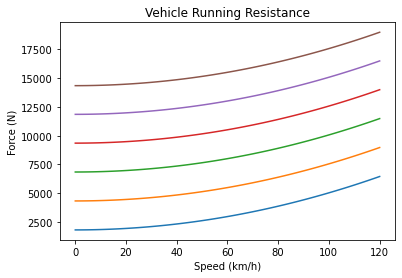

In [25]:
fig, ax = plt.subplots()
for i in range (0,len(variasi_array)):
    ax.plot(v_runres, runres_vehicle[:,i]);
ax.set(xlabel='Speed (km/h)', ylabel='Force (N)', title='Vehicle Running Resistance');
fig.savefig("motorrunres.png")

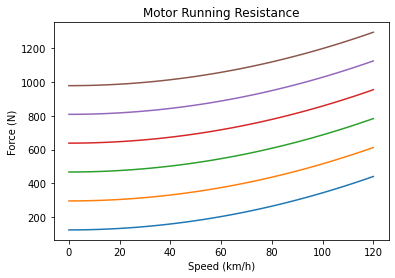

In [26]:
fig, ax = plt.subplots()
for i in range (0,len(variasi_array)):
    ax.plot(v_runres, runres_motor[:,i]);
ax.set(xlabel='Speed (km/h)', ylabel='Force (N)', title='Motor Running Resistance');

[Text(0.5, 0, 'Speed (km/h)'),
 Text(0, 0.5, 'Force (N)'),
 Text(0.5, 1.0, 'Wheel Running Resistance')]

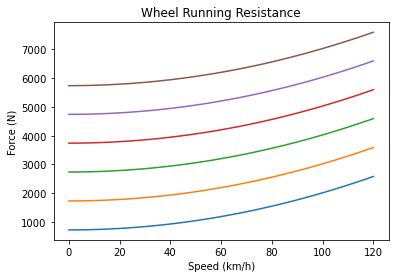

In [27]:
fig, ax = plt.subplots()
for i in range (0,len(variasi_array)):
    ax.plot(v_runres, runres_wheel[:,i]);
ax.set(xlabel='Speed (km/h)', ylabel='Force (N)', title='Wheel Running Resistance');


In [28]:
#Hasil kebutuhan traksi
# kec_arr = np.array([0, kec_operasi_kmh, kec_max_rpm])

In [29]:
#Tractive Effort

# tractive_effort_vehicle = massa_total*accel + runres_vehicle
# tractive_effort_motor   = massa_total*accel + runres_motor
# tractive_effort_wheel   = massa_total*accel + runres_wheel

# Mencari Vehicle Force
const_f = const_t*final_gr/jari_jari*gearbox
v_wp    = wp/3.6
const_p = const_f*v_wp

const_p_real = const_p/(v_runres[1:]/3.6)
const_p_real = np.insert(const_p_real,0,const_p_real[0])
const_f_real = np.full(shape=len(const_p_real),fill_value=const_f,dtype=np.int)

const_fp_real = np.concatenate((const_f_real,const_p_real))
const_fp_real = np.reshape(const_fp_real,(len(const_p_real),2),order='F')

#Tractive Effort
vehicle_force       = const_fp_real.min(axis=1)
wheel_torque        = vehicle_force*jari_jari
motor_torque        = wheel_torque/final_gr/mech_eff
motor_cruise_torque = motor_torque*cruise_percentage/100

vehicle_force_arr = vehicle_force.reshape(vehicle_force.shape[0],-1)
temp = vehicle_force_arr
for i in range (0,5):
    vehicle_force_arr = np.concatenate((vehicle_force_arr,temp),axis=1)
# print ( np.concatenate((,vehicle_force),axis=1))
# print(vehicle_force_arr)

accel_real     = np.subtract(vehicle_force_arr,runres_vehicle)/massa_total

for i in range (len(accel_real)):
    if accel_real[i,0] < 0:
        break
    idx = i

avg_accel_real  = accel_real[:idx,0].mean()
p_motor         = (const_t*mech_eff*final_gr/jari_jari)*(wp/3.6)/1000
highacc_wp = 3.6*p_motor*1000*jari_jari/highacc_const_t/final_gr
pt_cruise           = cruise_percentage/100*p_motor

#Traffic Effort Peak
const_f_peak = highacc_const_t*final_gr/jari_jari*mech_eff
v_wp_peak    = highacc_wp/3.6
const_p_peak = const_f_peak*v_wp_peak


const_p_peak_real = const_p_peak/(v_runres[1:]/3.6)
const_p_peak_real = np.insert(const_p_peak_real,0,const_p_peak_real[0])
const_f_peak_real = np.full(shape=len(const_p_peak_real),fill_value=const_f_peak,dtype=np.int)

const_fp_peak_real = np.concatenate((const_f_peak_real,const_p_peak_real))
const_fp_peak_real = np.reshape(const_fp_peak_real,(len(const_p_peak_real),2),order='F')

vehicle_force_peak       = const_fp_peak_real.min(axis=1)
wheel_torque_peak        = vehicle_force_peak*jari_jari
motor_torque_peak        = wheel_torque_peak/final_gr/mech_eff
motor_cruise_torque_peak = motor_torque_peak*cruise_percentage/100

print(v_wp_peak)
pd.DataFrame(motor_torque_peak)


7.053035809855497


<ipython-input-29-de8e65f3638e>:14: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  const_f_real = np.full(shape=len(const_p_real),fill_value=const_f,dtype=np.int)
<ipython-input-29-de8e65f3638e>:52: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for addition

,0
0,1251.877133
1,1251.877133
2,1251.877133
3,1251.877133
4,1251.877133
...,...
116,274.022845
117,271.680769
118,269.378390
119,267.114706


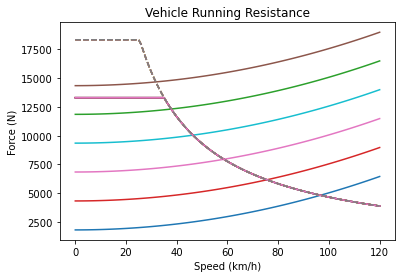

In [30]:
fig, ax = plt.subplots()
for i in range (0,len(variasi_array)):
    ax.plot(v_runres, runres_vehicle[:,i]);
    ax.plot(v_runres, vehicle_force[:]);
    ax.plot(v_runres, vehicle_force_peak[:],linestyle='--');
ax.set(xlabel='Speed (km/h)', ylabel='Force (N)', title='Vehicle Running Resistance');

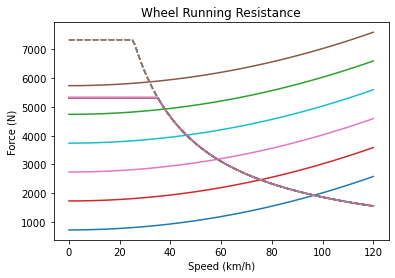

In [31]:
fig, ax = plt.subplots()
for i in range (0,len(variasi_array)):
    ax.plot(v_runres, runres_wheel[:,i]);
    ax.plot(v_runres, wheel_torque[:]);
    ax.plot(v_runres, wheel_torque_peak[:],linestyle='--');
ax.set(xlabel='Speed (km/h)', ylabel='Force (N)', title='Wheel Running Resistance');

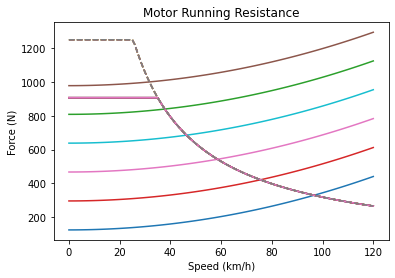

In [32]:
fig, ax = plt.subplots()
for i in range (0,len(variasi_array)):
    ax.plot(v_runres, runres_motor[:,i]);
    ax.plot(v_runres, motor_torque[:]);
    ax.plot(v_runres, motor_torque_peak[:],linestyle='--');
ax.set(xlabel='Speed (km/h)', ylabel='Force (N)', title='Motor Running Resistance');

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


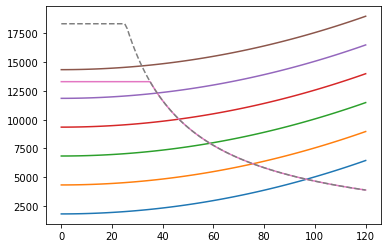

<Figure size 432x288 with 0 Axes>

In [38]:
        fig = plt.figure("Line Plot")
        legendFig = plt.figure("Legend plot")
        ax = fig.add_subplot(111)
        for i in range (0,len(variasi_array)):
            line1, = ax.plot(v_runres, runres_vehicle[:,i],label = "Runres " + str(gradien[i]) + "'");
        line2, = ax.plot(v_runres, vehicle_force,label = "Vehicle Force (N)")
        line3, = ax.plot(v_runres, vehicle_force_peak,linestyle='--',label = "Vehicle Force Peak (N)")
        for i in range (0,len(variasi_array)):
            legendFig.legend([line1,line2,line3],["Runres " + str(gradien[i]) + "'","Vehicle Force (N)","Vehicle Force Peak (N)"], loc='center')
        legendFig.savefig('legend.png')
        # ax.set(xlabel='Speed (km/h)', ylabel='Force (N)', title='Vehicle Running Resistance');
        # ax.legend(bbox_to_anchor=[1.17, 1.15], loc='upper right')
        # fig.legend([line1], ['series1'], bbox_to_anchor=[0.5, 0.5], loc='center left')
        fig.savefig("plot_vehicleforce.png")

In [33]:
#Screen Size
import sys
from PyQt5 import QtWidgets

app = QtWidgets.QApplication(sys.argv)

screen = app.primaryScreen()
print('Screen: %s' % screen.name())
size = screen.size()
print('Size: %d x %d' % (size.width(), size.height()))
rect = screen.availableGeometry()
print('Available: %d x %d' % (rect.width(), rect.height()))

AttributeError: 'NoneType' object has no attribute 'name'

In [ ]:
from fpdf import FPDF

pdf_w=210
pdf_h=297

p_motor=1;


class PDF(FPDF):
    def titles(self):

        #Halaman 1
        self.add_page()

        #Set Warna
        self.set_text_color(0, 0, 0)\
        
        #Judul
        self.set_xy(0.0,0.0)
        self.set_font('Arial', 'B', 16)
        self.cell(w=210.0, h=40.0, align='C', txt="PERFORMANCE REPORT", border=0)


        #Design Summary
        self.set_xy(10.0,35.0)
        self.set_font('Arial', 'B', 12)
        self.cell(w=0.0, h=0.0, align='L', txt="Design Summary", border=0)

        self.set_xy(10.0,45.0)
        self.set_font('Arial', '', 11)
        self.cell(w=0.0, h=0.0, align='L', txt="Motor Power =", border=0)

        self.set_xy(10.0,50.0)
        self.cell(w=0.0, h=0.0, align='L', txt="Motor Nom Torque =", border=0)

        self.set_xy(10.0,55.0)
        self.cell(w=0.0, h=0.0, align='L', txt="Motor Peak Torque =", border=0)

        self.set_xy(10.0,60.0)
        self.cell(w=0.0, h=0.0, align='L', txt="Motor RPM =", border=0)

        self.set_xy(100.0,45.0)
        self.cell(w=0.0, h=0.0, align='L', txt="Gradeability =", border=0)
        
        self.set_xy(100.0,50.0)
        self.cell(w=0.0, h=0.0, align='L', txt="Battery Power =", border=0)

        self.set_xy(100.0,55.0)
        self.cell(w=0.0, h=0.0, align='L', txt="Battery Energy =", border=0)

        self.set_xy(100.0,60.0)
        self.cell(w=0.0, h=0.0, align='L', txt="Final Gear Ratio =", border=0)

        #Grafik Motor Running Resistance
        self.set_xy(10.0,70.0)
        self.set_font('Arial', 'B', 12)
        self.cell(w=0.0, h=0.0, align='L', txt="Grafik  Motor Running Resistance", border=0)

        self.set_xy(40.0,70.0)
        self.image('motorrunres.png',  link='', type='', w=700/5, h=450/5)

        #Parameter Kendaraan
        self.set_xy(10.0,170.0)
        self.set_font('Arial', 'B', 12)
        self.cell(w=0.0, h=0.0, align='L', txt="Parameter Kendaraan", border=0)

        self.set_xy(10.0,180.0)
        self.set_font('Arial', '', 11)
        self.cell(w=0.0, h=0.0, align='L', txt="Lebar Kendaraan =", border=0)

        self.set_xy(10.0,185.0)
        self.cell(w=0.0, h=0.0, align='L', txt="Tinggi Kendaraan =", border=0)

        self.set_xy(10.0,190.0)
        self.cell(w=0.0, h=0.0, align='L', txt="Ca =", border=0)

        self.set_xy(10.0,195.0)
        self.cell(w=0.0, h=0.0, align='L', txt="Af =", border=0)

        self.set_xy(10.0,205.0)
        self.cell(w=0.0, h=0.0, align='L', txt="Kode Ban =", border=0)

        self.set_xy(10.0,210.0)
        self.cell(w=0.0, h=0.0, align='L', txt="Jari - jari Ban =", border=0)

        self.set_xy(100.0,180.0)
        self.cell(w=0.0, h=0.0, align='L', txt="Massa Kosong =", border=0)

        self.set_xy(100.0,185.0)
        self.cell(w=0.0, h=0.0, align='L', txt="Massa Isi =", border=0)

        self.set_xy(100.0,190.0)
        self.cell(w=0.0, h=0.0, align='L', txt="Massa Total =", border=0)

        self.set_xy(100.0,200.0)
        self.cell(w=0.0, h=0.0, align='L', txt="Gear Box =", border=0)
        
        self.set_xy(100.0,205.0)
        self.cell(w=0.0, h=0.0, align='L', txt="Axle =", border=0)

        self.set_xy(100.0,210.0)
        self.cell(w=0.0, h=0.0, align='L', txt="Final GR =", border=0)

        self.set_xy(150.0,200.0)
        self.cell(w=0.0, h=0.0, align='L', txt="Mech Eff =", border=0)

        #Dinamika Bergerak
        self.set_xy(10.0,220.0)
        self.set_font('Arial', 'B', 12)
        self.cell(w=0.0, h=0.0, align='L', txt="Dinamika Bergerak", border=0)

        self.set_xy(10.0,230.0)
        self.set_font('Arial', '', 11)
        self.cell(w=0.0, h=0.0, align='L', txt="Rolling Resistance =", border=0)

        self.set_xy(10.0,235.0)
        self.cell(w=0.0, h=0.0, align='L', txt="Drag Resistance =", border=0)

        self.set_xy(10.0,240.0)
        self.cell(w=0.0, h=0.0, align='L', txt="Massa Jenis Udara =", border=0)

        self.set_xy(100.0,230.0)
        self.cell(w=0.0, h=0.0, align='L', txt="Kecepatan Angin =", border=0)

        self.set_xy(100.0,235.0)
        self.cell(w=0.0, h=0.0, align='L', txt="Percepatan Gravitasi =", border=0)

        self.set_xy(100.0,240.0)
        self.cell(w=0.0, h=0.0, align='L', txt="Acceleration Margin =", border=0)

        #Halaman 2
        self.add_page()

        #Vehicle Running Resistance
        self.set_xy(10.0,10.0)
        self.set_font('Arial', 'B', 12)
        self.cell(w=0.0, h=0.0, align='L', txt="Grafik Vehicle Running Resistance", border=0)

        self.set_xy(30.0,15.0)
        self.image('rumus_vehiclerunres.png',  link='', type='', w=0, h=0)

        self.set_xy(40.0,35.0)
        self.image('motorrunres.png',  link='', type='', w=0, h=0)

        #Wheel Running Resistance
        self.set_xy(10.0,145.0)
        self.set_font('Arial', 'B', 12)
        self.cell(w=0.0, h=0.0, align='L', txt="Grafik Wheel Running Resistance", border=0)

        self.set_xy(30.0,150.0)
        self.image('rumus_wheelrunres.png',  link='', type='', w=0, h=0)

        self.set_xy(40.0,170.0)
        self.image('motorrunres.png',  link='', type='', w=0, h=0)


        


 
    def lines(self):
        self.set_line_width(0.5)
        self.line(5.0,5.0,205.0,5.0) # top one
        self.line(5.0,292.0,205.0,292.0) # bottom one
        self.line(5.0,5.0,5.0,292.0) # left one
        self.line(205.0,5.0,205.0,292.0) # right one

    def charts(self):
        self.set_xy(40.0,35.0)
        self.image('motorrunres.png',  link='', type='', w=700/10, h=450/10)

    

pdf = PDF(orientation='P', unit='mm', format='A4')
# pdf.add_page()

# pdf.lines()
pdf.titles()
pdf.set_author('INKA')
# pdf.charts()
pdf.output('report.pdf','F')


''